(supervised:general:example-knn)=
# Introductory Example (k-NN)

To demonstrate basic principles of supervised learning and their realization with Scikit-Learn we introduce the simplest supervised learning method here, the *k-nearest neighbors method* (k-NN).

## Method

k-NN is a method without trainable parameters. Such non-parametric methods do not need a training phase (but may require hyperparameter optimization). All computations are done in the prediction phase. Thus, in contrast to almost all other machine learning methods, training is ver cheap and predictions are computationally expensive.

Given a feature vector $x$ we look for the $k$ training samples closest to $x$ and make a prediction from those $k$ neighbors:
* For classification problems we use the class appearing most often among the neighbors as prediction $y$.
* For regression problems we use the mean of the labels of all neighbors as prediction $y$.

Here $k$ is a hyperparameter determining the size of the neighborhood predictions are based on. Different metrics for calculating distances in the feature space may be used, but Euclidean distance is the standard choice. The metric can be regarded as a hyperparameter, too.

The $k$-NN method per prediction requires as many distance computations in the feature space as there are samples in the training data set. Thus, for very large data sets $k$-NN might be computationally infeasible.

## Scaling

To ensure comparable influence of all features on the computed distances all features should have similar numerical range. Else features with high numerical values would dominate the distance measure. This scaling problem arises for almost all machine learning methods and will be discussed in detail in [](supervised:general:scaling).

**Example**

Consider classification of used cars with features age (in years) and kilometers driven. Classes might be 'low quality' and 'high quality', but do not matter here. We look at three samples:
\begin{equation*}
x_1=(1, 100000),\quad x_2=(11, 100000),\quad x_3=(1, 99990).
\end{equation*}
To predict the quality of sample $x_1$ with k-NN we have to compute distances to all other samples. For both $x_2$ and $x_3$ the distance is $\sqrt{10^2+0^2}=10$. That is, an age difference of 10 years (with equal kilometers) has the same influence on predictions like a kilometer difference of 10 (with equal age). The age difference should be very relevant for the car's quality, but the tiny kilometer difference won't.

Rescaling the kilometer feature by factor 1000, that is, expressing the feature as multiples of 1000 kilometers, the samples look like
\begin{equation*}
x_1=(1, 100),\quad x_2=(11, 100),\quad x_3=(1, 99.99)
\end{equation*}
and distances of $x_1$ to $x_2$ and $x_3$ are 10 and 0.01, respectively. Now the old car $x_2$ is a lot further away from $x_1$ than the young car $x_3$. Consequently, $x_3$ is much more likely to influence k-NN predictions for $x_1$ than $x_2$.

```{important}
**Prepare your data well!**

The example above shows that correct data preprocessing is of utmost importance. Even simple steps like scaling may alter results obtained from machine learning methods significantly.
```

## Weights

Often $k$-NN includes some kind of weighting. A common approach is to weight the feature vectors by their distance to the feature vector we want to predict the label for. Denote by $d_1,\ldots,d_k$ the distances of the $k$ nearest neighbors and $y_1,\ldots, y_k$ are corresponding labels.

For regressions tasks the prediction then is
\begin{equation*}
y_{\mathrm{pred}}=\frac{\sum\limits_{\kappa=1}^{k}\frac{1}{d_\kappa}\,y_\kappa}{\sum\limits_{\kappa=1}^{k}\frac{1}{d_\kappa}}.
\end{equation*}
Note that weights always have to add up to 1 for regression tasks.

For classification tasks distance-weighted k-NN predicts the class for which the sum of all weights in the neighborhood is maximal:
\begin{equation*}
y_{\mathrm{pred}}=\mathop{\mathrm{argmax}}\limits_{c\in\{1,\ldots,C\}}\,\sum_{\substack{\kappa\in\{1,\ldots,k\}\\y_\kappa=c}}\frac{1}{d_\kappa}
\end{equation*}
Here classes are denoted $1,\ldots,C$.

Whenever Scikit-Learns wants to have a data set, it expects a Numpy array of shape $n\times m$, where $n$ is the number of samples in the data set and $m$ is the number of features. Corresponding labels (for training) have to be provided in a one-dimensional array of length $n$.

## k-NN with Scikit-Learn

All methods implemented in Scikit-Learn follow the same approach:
1. Create a suitable Scikit-Learn object, which provides the method and encapsulates parameters and hyperparameters as well as results.
2. Call the object's `fit` method (that's the training step).
3. Investigate results (parameters and so on, depending on the method).
4. Call the object's `predict` method to predict labels for non-training data.

Scikit-Learn implements k-NN regression in [`KNeighborsRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html) and k-NN classification in [`KNeighborsClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html).
The `fit` method stores training data internally (remember, k-NN requires no training) and `predict` then uses stored training data for calculating the distances and choosing a prediction.

The import name of Scikit-Learn is `sklearn`. The installation name is `scikit-learn`.

### Regression Example

For demonstration we use a small one-feature synthetic data set.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sklearn.neighbors as neighbors
import sklearn.model_selection as model_selection
import sklearn.metrics as metrics

rng = np.random.default_rng(42)

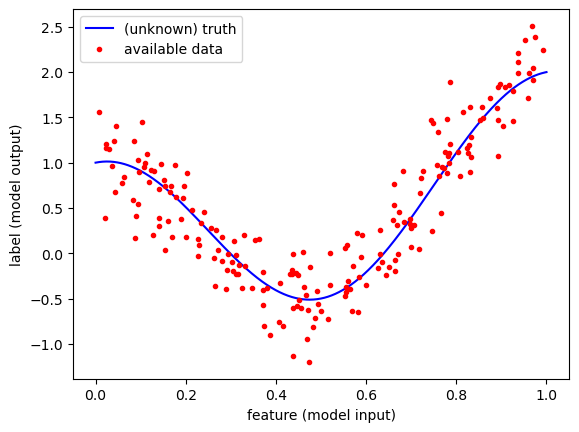

In [2]:
def truth(x):
    return x + np.cos(2 * np.pi * x)

xmin = 0
xmax = 1
x = np.linspace(xmin, xmax, 1000)

n = 200    # number of data points to generate
noise_level = 0.3    # standard deviation of artificial noise

# simulate data
X = (xmax - xmin) * rng.random((n, 1)) + xmin
y = truth(X).reshape(-1) + noise_level * rng.standard_normal(n)

# plot truth and data
fig, ax = plt.subplots()
ax.plot(x, truth(x), '-b', label='(unknown) truth')
ax.plot(X.reshape(-1), y, 'or', markersize=3, label='available data')
ax.legend()
ax.set_xlabel('feature (model input)')
ax.set_ylabel('label (model output)')
plt.show()

Weightless $k$-NN (`weights='uniform'`) yields piecewise constant hypotheses, which can be seen by using small `n`. This is not true if weighting by distance is used (`weights='distance'`).

To evaluate the model's prediction quality after training we have to split our data set into a training set and a test set. Training and test samples should be chosen at random to avoid bias due to sorted or otherwise structured samples. Scikit-Learn provides [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) in its `model_selection` module for this purpose. For the moment we do not consider hyperparameter optimization. Thus, no validation set is needed.

In [3]:
# split data into train and test sets
X_train, X_test, y_train, y_test \
    = model_selection.train_test_split(X, y, test_size=0.3, random_state=0)
print(y_train.size, y_test.size)

# regression
knn = neighbors.KNeighborsRegressor(10, weights='uniform')
knn.fit(X_train, y_train)

# get predictions in grid for plotting the hypothesis
y_knn = knn.predict(x.reshape(-1, 1))

# plot truth, data, hypothesis
fig, ax = plt.subplots()
ax.plot(x, truth(x), '-b', label='(unknown) truth')
ax.plot(X_train.reshape(-1), y_train, 'or', markersize=3, label='training data')
ax.plot(X_test.reshape(-1), y_test, 'xr', markersize=5, label='test data')
ax.plot(x, y_knn, '-g', label='trained model')
ax.legend()
ax.set_xlabel('feature (model input)')
ax.set_ylabel('label (model output)')
plt.show()

140 60


In the evaluation phase we calculate some suitable metric on the test set. Here we use [mean squared error (MSE)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html).

In [4]:
print('test error:', metrics.mean_squared_error(y_test, knn.predict(X_test)))
print('train error:', metrics.mean_squared_error(y_train, knn.predict(X_train)))

test error: 0.10849356915074192
train error: 0.07957991672205268


Now we may use the trained model to get predictions for arbitrary inputs. Simply call the model's [`predict`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor.predict) method.

### Classification Example

Here is a synthetic two-feature binary classification example.

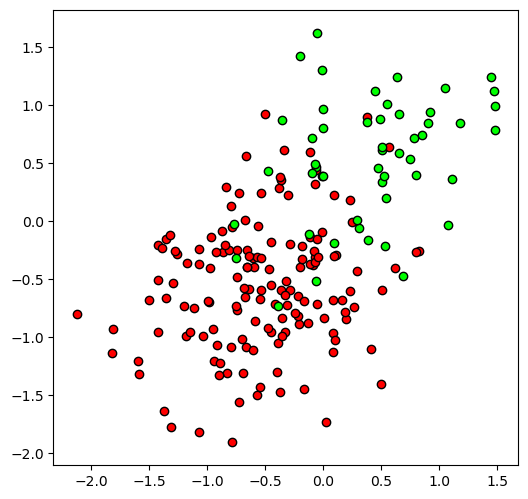

In [5]:
n0 = 150    # training samples in class 0
n1 = 50    # training samples in class 1

# generate two point clouds (classes)
X0 = rng.multivariate_normal([-0.5, -0.5], [[0.3, 0], [0, 0.3]], size=n0)
X1 = rng.multivariate_normal([0.5, 0.5], [[0.3, 0], [0, 0.3]], size=n1)
X = np.concatenate((X0, X1))

# set labels
y0 = np.zeros(n0, dtype=np.uint8)
y1 = np.ones(n1, dtype=np.uint8)
y = np.concatenate((y0, y1))

# set plotting region
x0_min = X[:, 0].min() - 0.2
x0_max = X[:, 0].max() + 0.2
x1_min = X[:, 1].min() - 0.2
x1_max = X[:, 1].max() + 0.2

# plot data set
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(X[y == 0, 0], X[y == 0, 1], c='#ff0000', edgecolor='black')
ax.scatter(X[y == 1, 0], X[y == 1, 1], c='#00ff00', edgecolor='black')
ax.set_xlim(x0_min, x0_max)
ax.set_ylim(x1_min, x1_max)
ax.set_aspect('equal')
plt.show()

In [6]:
from matplotlib.colors import LinearSegmentedColormap

X_train, X_test, y_train, y_test \
    = model_selection.train_test_split(X, y, test_size=0.3, random_state=0)
print(y_train.size, y_test.size)

knn = neighbors.KNeighborsClassifier(5, weights='uniform')
knn.fit(X_train, y_train)

fig, ax = plt.subplots(figsize=(6, 6))

# plot trained model (function values color-coded)
x0, x1 = np.meshgrid(np.linspace(x0_min, x0_max, 100), np.linspace(x1_min, x1_max, 100))
X_grid = np.concatenate((x0.reshape(-1, 1), x1.reshape(-1, 1)), axis=1)
y_grid = knn.predict(X_grid).reshape(100, 100)
cm = LinearSegmentedColormap.from_list('rg', ['#ff0000', '#00ff00'])
ax.contourf(x0, x1, y_grid, cmap=cm, levels=np.linspace(0, 1, 10))

# plot decision boundary
ax.contour(x0, x1, y_grid, levels=[0.5], linewidths=[2], colors=['#ffff00'])

# plot training and test data
ax.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], c='#ff0000', edgecolor='black', zorder=1000)
ax.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], c='#00ff00', edgecolor='black', zorder=1000)
ax.scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], c='#ff0000', edgecolor='white', zorder=1000)
ax.scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], c='#00ff00', edgecolor='white', zorder=1000)

ax.set_xlim(x0_min, x0_max)
ax.set_ylim(x1_min, x1_max)
ax.set_aspect('equal')

plt.show()

# evaluation
print('test accuracy:', metrics.accuracy_score(y_test, knn.predict(X_test)))
print('train accuracy:', metrics.accuracy_score(y_train, knn.predict(X_train)))

140 60


test accuracy: 0.9166666666666666
train accuracy: 0.9214285714285714


Here we used [accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) as quality measure.

## Further Aspects to Consider

### Odd k for Binary Classification

In binary classification even $k$ may result in deadlocks, which typically are handled by random choice of one class. Obviously, it's a good idea to choose odd $k$.

### Imbalanced Classes

Care has to be taken with imbalanced classes. If one class has much more samples than other classes, then that class might dominate almost all neighborhoods and samples from smaller classes get outshined.

Imbalanced classes are a serious problem in machine learning if one wants to classify rare events or objects like failures in production lines, for instance (inputs are sensor data, output is failture/no failture).  It's easy to get lots of positive (no failure) samples. But there will be only few training samples from the failure class.

Possible solutions are dropping samples from the larger class or to introduce weights based on expected or actual class sizes (in the production line example: multiply distances to 'no failure' samples by expected failure rate). Details heavily depend on the concrete context.

Try
```python
n0 = 300
n1 = 10

X0 = rng.multivariate_normal([-0.5, -0.5], [[0.3, 0], [0, 0.3]], size=n0)
X1 = rng.multivariate_normal([-0.5, -0.5], [[0.01, 0], [0, 0.01]], size=n1)
```
in the classification example above. The small region with green samples is surrounded and permeated by lots of red samples. Thus, even in the green region neighborhoods contain more red than green samples.

```{important}
**There is no standard solution!** and **Know your data!**

Each machine learning task comes with its own set of difficulties. Even the application of simple methods like k-NN requires a considerable amount of brain-work to get useful and reliable results. The most important step is to know and understand your data.
```

### The Curse of Dimensionality

If the hyperparameter $k$ is too large, then predictions will be stable (altering/removing individual neighbors won't change predictions) but inaccurate (very distant samples influence predictions). If $k$ is too small, then predictions are very sensitive to modifications and noise in the training data.

#### Exponential Growth of k

It's important to note that the choice of $k$ heavily depends on the dimension $m$ of the feature space. In higher dimensions we have to look at much more neighbors to get sufficient information about the local behavior of the approximated function. More precisely, $k$ should be proportional to $2^m$ (this fact is of little use for choosing concrete $k$, but it's a good starting point for developing some intuition on choosing good hyperparameters).

Imagine the vertices of a hypercube in $m$-dimensional space. For $m=1$ it's an interval with two vertices (end points). For $m=2$ it's a square with four vertices. For $m=3$ it's a usual cube with $8$ vertices. For general $m$ a hypercube has $2^m$ vertices. If (in average) we want to have one neighbor on each 'side' of an input (more precisely: one neighbor per [orthant](https://en.wikipedia.org/wiki/Orthant)), we have to set $k=2^m$. Such heavy influence of space dimension is sometimes called the *curse of dimensionality*.

```{figure} neighbors.svg
---
alt: 1d, 2d, 3d cube and its vertices
scale: 80%
---
Even if a point of interest only has neighbors at the vertices of a surrounding cube, number of neighbors grows exponentially with dimension.
```

#### Distances in High Dimensions

The curse of dimensionality causes also another problem: in high dimensions almost all distances between points are large and almost identical. The higher the space dimension the less dense the data set.

To understand the problem in more detail we consider $n$ feature vectors uniformly distributed in the $m$-dimensional hypercube $[0,1]^m$. Fix some feature vector (the one we want to predict the label for) and a hypersphere with radius $R$ centered at that feature vector. Denote the number of feature vectors inside the hypersphere by $k$. Then, due to uniformly distributed data, $\frac{k}{n}$ will be very close to the volume of a hypersphere divided by the hypercube's volume. The hypercube has volume one. Thus,
\begin{equation*}
\frac{k}{n}\approx\text{volume of hypersphere}\qquad\text{or}\qquad k\approx n\cdot\text{volume of hypersphere}.
\end{equation*}
Have a look at the [volume of the hypersphere (Wikipedia)](https://en.wikipedia.org/wiki/Volume_of_an_n-ball) with radius $R$:

| dimension | volume | volume for $R=0.1$ |
|-----|------:|:------|
| 1 | $2\,R$ | $0.2$ |
| 2 | $3.142\,R^2$ | $0.0342$ |
| 3 | $4.189\,R^3$ | $0.004189$ |
| 4 | $4.935\,R^4$ | $0.0004934$ |
| 5 | $5.264\,R^5$| $0.00005264$ |

The volume of a hypersphere drastically decreases (compared to the cubes volume) if dimension grows. Thus, the number of feature vectors inside the sphere decreases with growing dimension. Or the other way round: the higher the dimension the farther away are neighboring points. Consequently, almost all points seem to be close to the surface of the hypercube and the interior is more or less empty.

But remember: throughout the dimensionality discussion we assumed that points are uniformly (!) distributed in space. The problem is the Euclidean distance which is not able to grasp this uniform distribution in high dimensions.

The following code illustrates the theoretical considerations numerically (Scikit-Learn's [`pairwise_distances`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances.html) saves some work here):

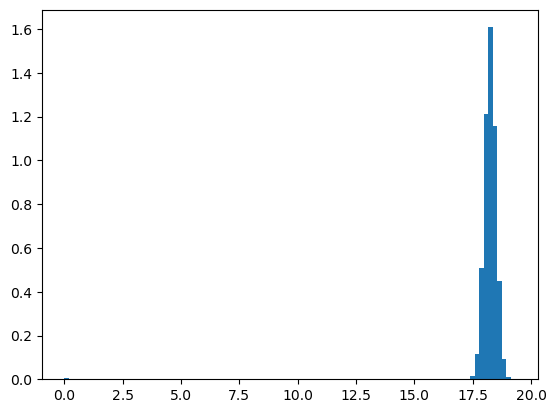

In [7]:
from sklearn.metrics import pairwise_distances

dim = 2000    # dimension of data space
n = 1000    # number of samples

# generate samples uniformly distributed in unit (hyper)cube
X = rng.uniform(dim * (0,), dim * (1,), (n, dim))

# calculate pairwise distances between samples
dists = pairwise_distances(X).reshape(-1)

# plot histogram of pairwise distances
fig, ax = plt.subplots()
ax.hist(dists, 100, density=True)
plt.show()

Try different values for `dim`: 2, 20, 200, 200.

#### Don't Buy High-Dimensional Melons

From the above discussion we may deduce that high-dimensional melons only consist of green skin with only very little red interior. We may compute this result directly. To simplify calculations we assume that a melon is a cube and one tenth of the edge length $l$ is green skin. Then in $m$ dimensions the red interiors volume compared to the melon's total volume is
\begin{equation*}
\frac{V_{\mathrm{red}}}{V_{\mathrm{total}}}=\frac{(0.9\,l)^m}{l^m}=0.9^m,
\end{equation*}
which goes to zero for $m\to\infty$.

For spheric melons similar computations yield exactly the same result $0.9^m$.

```{figure} melon.svg
---
alt: 1d, 2d, 3d balls/melons and size of their interior
scale: 80%
---
The best melon is a 1d melon. But 3d melons are okay, too.
```

#### Practical Implications

Increasing the size of the training data set might help to overcome the curse of dimensionality. But we would have to collect much more data than possible if dimension of feature space is high. Some concrete numbers: In a 30-dimensional feature space (say a hypercube) we have 1 billion vertices. Thus, we would need 1 billion samples to have at least one sample per vertex in average. In two dimensions equivalent data set size would be 4 samples (one per vertex).

There is also some good news. Most data sets are not uniformly distributed. Instead samples concentrate around lower-dimensional manifolds. Thus, we do not have to cover the entire space with samples. Feature/dimensionality reduction is an important preprocessing step for k-NN, see [](supervised:general:feature-reduction).

```{important}
**Math matters!**

Human imagination fails in high dimensions. Math still works.
```